# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Импортируем необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

Загрузим датафрейм и выведем его первые 5 строк

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Узнаем общую информацию про полученный датафрейм

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим общую гистограмму для всех стролбцов датафрейма

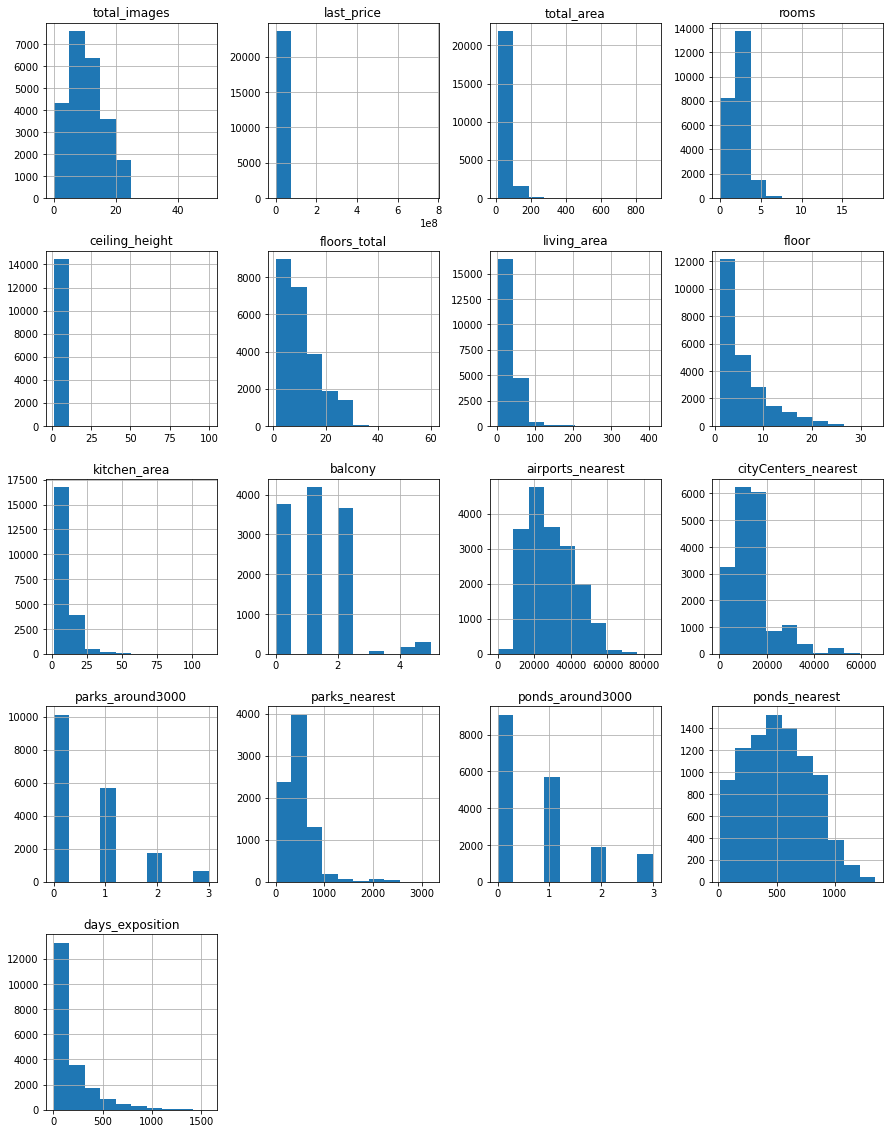

In [4]:
data.hist(figsize=(15,20));

**Вывод: Изучив полученный датафрейм можно сказать, что в нем присутствует большое количество пропусков и некоторые столбцы не соответствуют типам данных, которые лучше всего подходят для них. Построенные гистограммы явно смещены влево, возможно это из-за пропусков в нашем датафрейме.**

### Предобработка данных

#### Обработка пропусков

Проверим, все ли колонки соотвествуют змеиному регистру

In [5]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Переменуем колонку, которая не соотвествует змеиному регистру

In [6]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

Найдем количество пропусков в датафрейме

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Пропуск в столбце balcony скорее всего связан с отсутствием балкона в квартире, поэтому пропуски можно заменить нулем.**

**Пропуск в столбце is_apartment скорее всего связан с тем, что квартиры не является апартаментами, поэтому заменим все пропуски значением False.**


In [8]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)

Проверим, есть ли такие квартиры, у которых указано расстояние до ближайшего парка, но стоит пропуск в столбце с количеством парков в радиусе 3 км.

In [9]:
len(data.loc[(~data['parks_nearest'].isna()) & (data['parks_around3000'].isna())])

0

Таких квартир нет, значит пропуск означает отсутствие парка в радиусе 3 км

In [10]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

Проверим количество пропусков в столбце parks_nearest, если количество парков в радиусе 3 км равно нулю. 

In [11]:
len(data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'].isna())])

15620

**Количество ячеек с пропусками соответствует общему количеству пропусков по столбцу parks_nearest, значит люди просто не указывали расстояние до парка, если их нет в радиусе 3 км.**

Проделаем тоже самое, только для водоемов

In [12]:
len(data.loc[(~data['ponds_nearest'].isna()) & (data['ponds_around3000'].isna())])

0

In [13]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [14]:
len(data.loc[(data['ponds_around3000'] == 0) & (data['ponds_nearest'].isna())])

14589

**Количество ячеек с пропусками соответствует общему количеству пропусков по столбцу ponds_nearest, значит люди просто не указывали расстояние до водоема, если их нет в радиусе 3 км.**

Так как скорее всего параметры квартиры зависят от количества комнат, то запеним пропуски в параметрах медианой, по параметру rooms

In [15]:
characteristics = ['ceiling_height', 'living_area', 'kitchen_area']

for room in data['rooms'].unique():
    for characteristic in characteristics:
        if characteristic == 'ceiling_height' and len(data.loc[data['rooms'] == room]) == 1:
            continue
        elif characteristic == 'kitchen_area' and room == 0:
            continue
        else:
            data.loc[(data['rooms'] == room) & (data[characteristic].isna()), characteristic] = \
            data.loc[data['rooms'] == room, characteristic].median()


В некоторых столбцах невозможно посчитать медиану, в таких столбцах пропуски остались на месте.

Посмотрим на оставшиеся пропуски в таблице

In [16]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              197
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

**C чем могут быть связаны оставшиеся пропуски:**

    - ceiling_height - единственная квартира, у которой остался пропуск, это квартира с 19ю комнатами. Возможно, это полноценный дом, где величина потолков может различаться 
    - floors_total - возможно это отдельны строения, либо продавец просто не указал этот параметр
    - kitchen_area - пропуски остались только у тех квартир, где количество комнат равно нулю. Это квартиры со свободной планировкой, где не было еще разграничений по комнатам
    - locality_name - ошибка при выгрузке, либо продавец просто не указал этот параметр
    - airports_nearest - скорее всего аэропорт слишком далеко, либо продавец просто не указал этот параметр
    - city_centers_nearest - скорее всего центр города слишком далеко, либо продавец просто не указал этот параметр
    - parks_nearest - ближайших парков в радиусе 3 км нет, поэтому продавец не стал указывать до них расстояние
    - ponds_nearest - ближайших водоемов в радиусе 3 км нет, поэтому продавец не стал указывать до них расстояние
    - days_exposition - либо объявление не было снято на момент выгрузки, либо объявление было очень быстро снято для дозаполнения каких-либо параметров


#### Обработка типов данных

Выведем еще раз общую информацию про наш датафрейм

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23698 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23502 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Взглянув на еще раз на общую информацию нашего датафрейма, можно сделать выво о том, в каких столбцах лучше поменять тип данных:**
* last_price - меняем на int, вряд ли цена по продаже квартиры будет указана с копейками
* balcony - меняем на int, балконов всегда целое число
* parks_around3000 - меняем на int, количество парков всегда целое число
* ponds_around3000 - меняем на int, количество водоемов всегда целое число

В других столбцах, где можно было бы поменять тип данных, присутствуют пропуски в данных

In [18]:
columns = ['last_price', 'balcony', 'parks_around3000', 'ponds_around3000']

for column in columns:
    data[column] = data[column].astype('int')

#### Поиск дубликатов

Рассмотрим названия населенных пунктов

In [19]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Удалим из названия населенных пунктов классификацию населенных пунктов

In [20]:
duplicates = [
    'посёлок ', 'городской ', 'поселок ', 'городского типа ', 'село ', 
    'деревня ', 'поселок городского типа ','садовое товарищество ',
    'при железнодорожной станции ','станции ', 'садоводческое некоммерческое товарищество ',
    'коттеджный '
]
data['locality_name'] = data['locality_name'].replace(duplicates, '', regex=True)

Рассмотрим еще раз названия населенных пунктов

In [21]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Теперь узнаем количество дубликатов

In [22]:
data.duplicated().sum()

0

#### Поиск анамальных значений

Перед восстановлением и удалением выбивающихся значений создадим переменную с количеством строк в датафрейме, чтобы узнать, какое количество выбивающихся значений мы удалим.  

In [23]:
old_data = data.shape[0]
old_data

23699

Восстановим искаженные значения

In [24]:
data[data['ceiling_height'] > 20]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,False,False,8.8,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259.0
3148,14,2900000,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,False,False,False,8.0,0,Волхов,NaN,NaN,0,NaN,0,NaN,NaN
4643,0,4300000,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,False,False,False,7.0,1,Санкт-Петербург,12016.0,13256.0,1,658.0,1,331.0,181.0
4876,7,3000000,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,False,False,True,NaN,2,Мурино,NaN,NaN,0,NaN,0,NaN,28.0
5076,0,3850000,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,False,False,5.5,0,Санкт-Петербург,29686.0,8389.0,3,397.0,1,578.0,7.0
5246,0,2500000,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,False,False,False,9.0,2,Мины,NaN,NaN,0,NaN,0,NaN,540.0
5669,4,4400000,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,False,False,False,7.0,2,Санкт-Петербург,28981.0,10912.0,1,305.0,0,NaN,267.0
5807,17,8150000,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,False,False,False,12.0,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38.0
6246,6,3300000,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,False,False,False,5.7,0,Кронштадт,68923.0,50649.0,1,417.0,2,73.0,NaN
9379,5,3950000,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,False,False,False,5.2,0,Санкт-Петербург,11647.0,13581.0,0,NaN,0,NaN,NaN


In [25]:
data['ceiling_height'] = data['ceiling_height'].replace(27, 2.7, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(24, 2.4, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.75, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(26, 2.6, regex=True)
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.26, regex=True)

Значение, где указано что высота потолков равно 100 м удалим

In [26]:
data = data.drop(22869).reset_index(drop=True)

Проверим выбивающиеся значения для стоимости квартир

Построим диаграмму размаха для визуального определения выбивающихся значений   

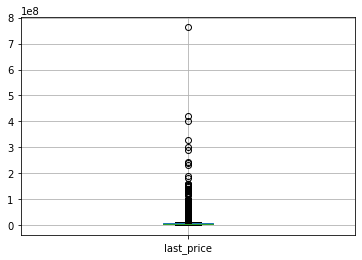

In [27]:
data.boxplot('last_price');

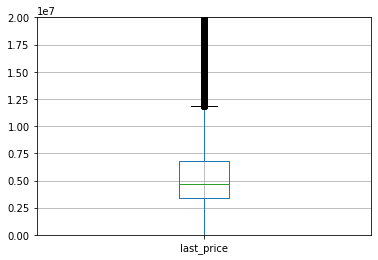

In [28]:
ax = data.boxplot('last_price')
ax.set_ylim(0,20000000)
ax;

In [29]:
len(data[data['last_price']>12000000])

1940

На диаграмме большое количество значений, которые лежат за границей “усов” графика. Удалять все значения, которые лежат за границей не будем, удалим значения выше 200000000 руб.   

In [30]:
data = data.query('last_price <= 200000000')

Проверим выбивающиеся значения для количества комнат в квартире 

Построим диаграмму размаха для визуального определения выбивающихся значений   

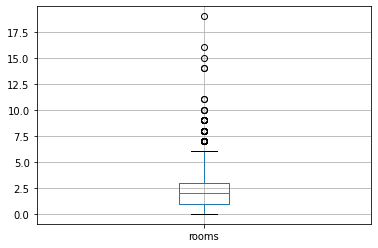

In [31]:
data.boxplot('rooms');

In [32]:
len(data[data['rooms']>6])

87

На диаграмме не большое количество значений, которые лежат за границей “усов” графика. Можно признать их выбросами и удалить из датафрейма.

In [33]:
data = data.query('rooms <= 6')

Проверим выбивающиеся значения для общей площади квартиры  

Построим диаграмму размаха для визуального определения выбивающихся значений   

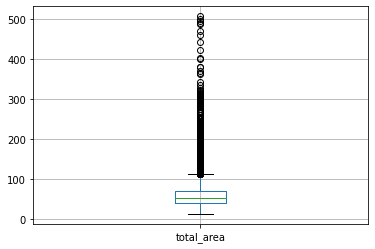

In [34]:
data.boxplot('total_area');

In [35]:
len(data[data['total_area']>110])

1280

На диаграмме большое количество значений, которые лежат за границей “усов” графика. Удалять все значения, которые лежат за границей не будем, удалим значения выше 300 м   

In [36]:
data = data.query('total_area <= 300')

Узнаем какой процент строк мы отбросили в результате исследования датафрейма

In [37]:
new_data = data.shape[0]
percent_delete = 100 - new_data / old_data * 100
percent_delete

0.5358875901936813

0.5% - процент строк, которые мы удалили. 0.5% меньше позволенных 10%, корректировка не нужна 

**Вывод: в результате предобработки, были заполнены некоторые пропуски с числовыми данными медианой, не числовые пропуски чья природа была ясна тоже были заполнены. Значения, которые сильно выбивались на фоне остальных были удалены. Проведен поиск дубликатов при помощи отброса классификации населенных пунктов, но дубликатов после проведенных манипуляций не оказалось** 

### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец с ценой за квадратный метр

In [38]:
data['price_per_meter'] = data['last_price'] / data['total_area']

Добавим столбец с днем недели публикации объявления

In [39]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")
data['week_day'] = data['first_day_exposition'].dt.weekday

Добавим столбец с месяцем публикации объявления

In [40]:
data['month'] = data['first_day_exposition'].dt.month

Добавим столбец с годом публикации объявления

In [41]:
data['year'] = data['first_day_exposition'].dt.year

Добавим столбец с типом этажа квартиры

In [42]:
def categorize_foor(row):
    if row['floors_total'] == row['floor']:
        return 'Последний'
    elif row['floor'] == 1:
        return 'Первый'
    else:
        return 'Другой'
    
data['type_floor'] = data.apply(categorize_foor, axis=1)

Добавим столбец с расстоянием до центра в км

In [43]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)

**Вывод: После проведенных расчетов, добавлены дополнительные столбцы для исследований данных**

### Проведите исследовательский анализ данных

Построим гистограмму для:
   * общая площадь;
   * жилая площадь;
   * площадь кухни;
   * цена объекта;
   * количество комнат;
   * высота потолков;
   * этаж квартиры;
   * тип этажа квартиры («первый», «последний», «другой»);
   * общее количество этажей в доме;
   * расстояние до центра города в метрах;
   * расстояние до ближайшего аэропорта;
   * расстояние до ближайшего парка;
   * день и месяц публикации объявления.

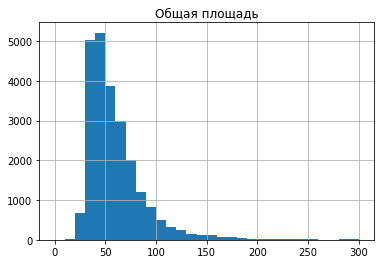

In [44]:
data['total_area'].hist(bins=30, range=(0,300))
plt.title('Общая площадь')
plt.show;

Больше всего объявлений было выставлено  для квартир с общей площадью близкой к 50 м

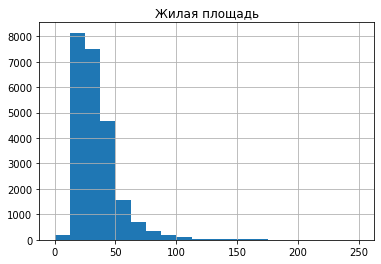

In [45]:
data['living_area'].hist(bins=20, range=(0,250))
plt.title('Жилая площадь')
plt.show;

Больше всего объявлений было выставлено для квартир с жилой площадью 20-40 м

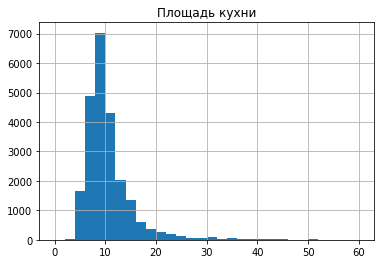

In [46]:
data['kitchen_area'].hist(bins=30, range=(0,60))
plt.title('Площадь кухни')
plt.show;

Больше всего объявлений было выставлено для квартир площадью кухни 8-10 м

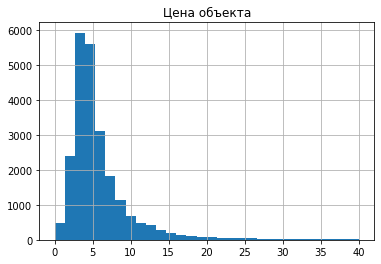

In [47]:
last_price_divided_one_mln = data['last_price'] / 1000000
last_price_divided_one_mln.hist(bins=30, range=(0,40))
plt.title('Цена объекта')
plt.show;

Больше всего объявлений было выставлено с ценой 2.5 – 3.75 млн.руб

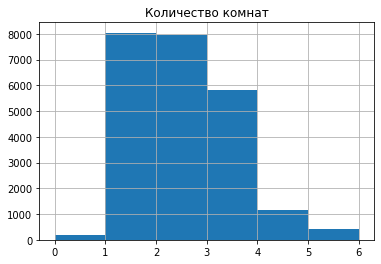

In [48]:
data['rooms'].hist(bins=6,range=(0,6))
plt.title('Количество комнат')
plt.show;

Больше всего объявлений было выставлено для квартир с 1 и 2мя комнатами

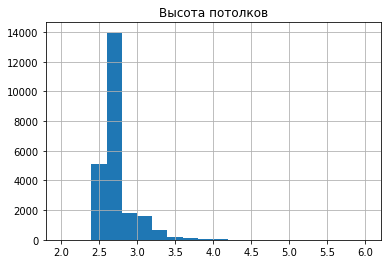

In [49]:
data['ceiling_height'].hist(bins=20, range=(2,6));
plt.title('Высота потолков')
plt.show;

Больше всего объявлений было выставлено для квартир высотой потолка близкой к 2.7 м

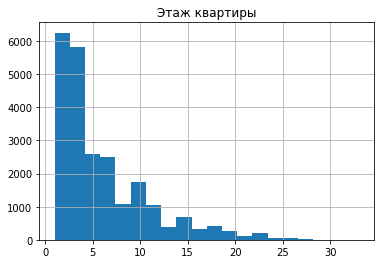

In [50]:
data['floor'].hist(bins=20);
plt.title('Этаж квартиры')
plt.show;

Больше всего объявлений было выставлено для квартир находящихся на 1-2 этаже

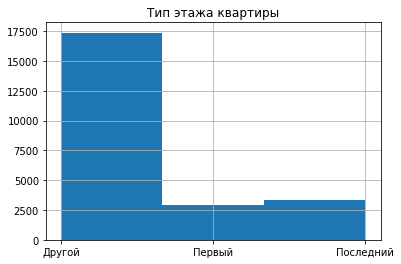

In [51]:
data['type_floor'].hist(bins=3);
plt.title('Тип этажа квартиры')
plt.show;

Больше всего объявлений было выставлено для квартир, находящихся не на первом и не на последнем этаже

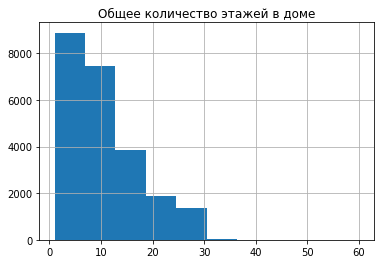

In [52]:
data['floors_total'].hist();
plt.title('Общее количество этажей в доме')
plt.show;

Больше всего объявлений было выставлено для квартир в домах ниже 8 этажа

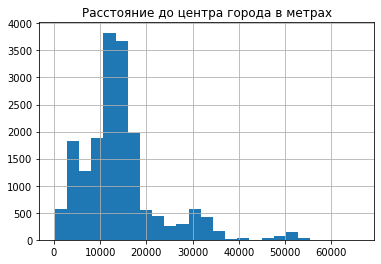

In [53]:
data['city_centers_nearest'].hist(bins=25);
plt.title('Расстояние до центра города в метрах')
plt.show;

Больше всего объявлений было выставлено для квартир, которые находятся на расстоянии 10000-15000 м от центра

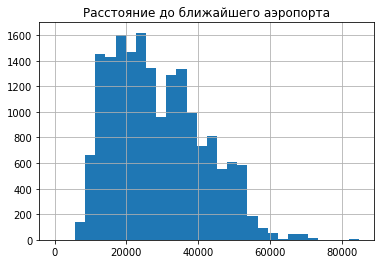

In [54]:
data['airports_nearest'].hist(bins=30);
plt.title('Расстояние до ближайшего аэропорта')
plt.show;

Больше всего объявлений было выставлено для квартир, которые находятся на расстоянии 23000-25000 м от аэропорта

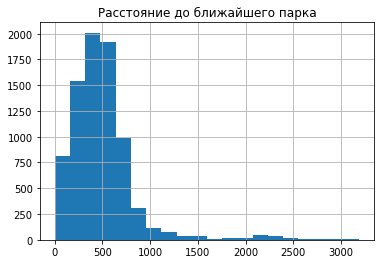

In [55]:
data['parks_nearest'].hist(bins=20);
plt.title('Расстояние до ближайшего парка')
plt.show;

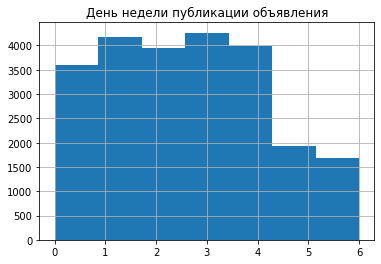

In [56]:
data['week_day'].hist(bins=7);
plt.title('День недели публикации объявления')
plt.show;

Чаще всего объявления выставляют в будние дни 

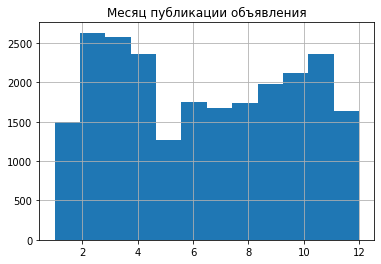

In [57]:
data['month'].hist(bins=12);
plt.title('Месяц публикации объявления')
plt.show;

Чаще всего объявления выставляют весной и в октябре 

Изучим, как быстро продавались квартиры

Построим гистограмму

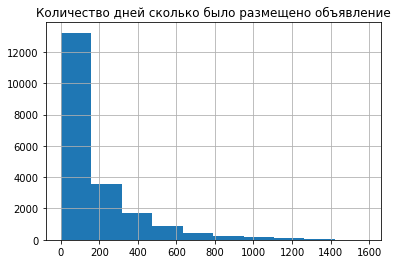

In [58]:
data['days_exposition'].hist();
plt.title('Количество дней сколько было размещено объявление')
plt.show;

Посчитаем среднее значение и медиану

In [59]:
data['days_exposition'].mean()

180.44286693429942

In [60]:
data['days_exposition'].median()

95.0

В среднем продажа занимает 180 дней. Продажу в течении 95 дней можно назвать быстрой, потому что она была совершена быстрее 50% всех объявлений 

Рассмотрим какие факторы больше всего влияют на общую (полную) стоимость объекта

Построим диаграмму рассеяния и вычислим коэффициент корреляции Пирсона для каждого фактора

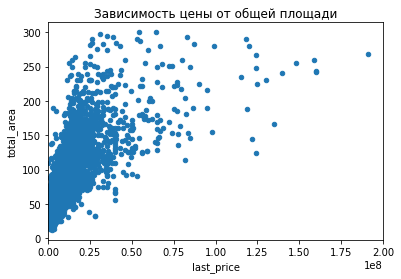

In [61]:
data.plot(x='last_price', y='total_area', kind='scatter',xlim=(0,200000000));
plt.title('Зависимость цены от общей площади')
plt.show;

In [62]:
data['total_area'].corr(data['last_price'])

0.7189894333198642

Общая площадь квартиры сильно влияет на цену

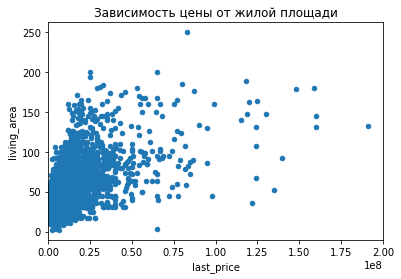

In [63]:
data.plot(x='last_price', y='living_area', kind='scatter',xlim=(0,200000000));
plt.title('Зависимость цены от жилой площади')
plt.show;

In [64]:
data['living_area'].corr(data['last_price'])

0.606237956520632

Жилая площадь квартиры сильно влияет на цену, но меньше, чем общая площадь 

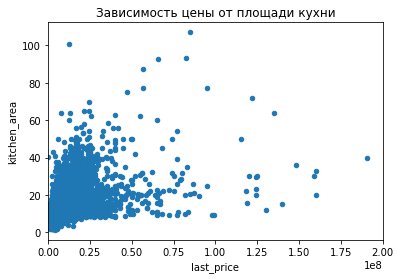

In [65]:
data.plot(x='last_price', y='kitchen_area', kind='scatter',xlim=(0,200000000));
plt.title('Зависимость цены от площади кухни')
plt.show;

In [66]:
data['kitchen_area'].corr(data['last_price'])

0.5240664294480575

Площадь кухни сильно влияет на цену, но меньше, чем общая площадь квартиры и жилая площадь квартиры 

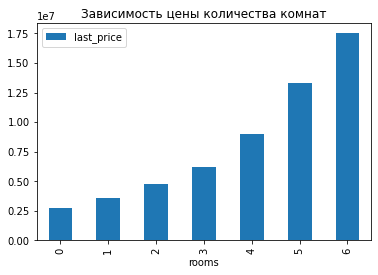

In [67]:
table_rooms = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
table_rooms.plot.bar(y='last_price');
plt.title('Зависимость цены количества комнат')
plt.show;

Количество комнат влияет на цену, с увеличением количества комнат, увеличивается и цена

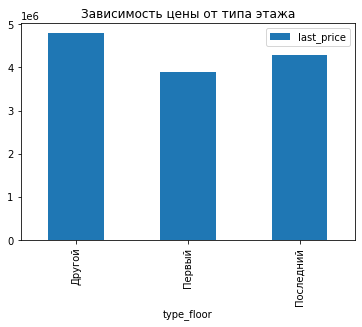

In [68]:
table_floor = data.pivot_table(index='type_floor', values='last_price', aggfunc='median')
table_floor.plot.bar();
plt.title('Зависимость цены от типа этажа')
plt.show;

Тип этажа влияет на цену квартиры. Квартиры, которые находятся на первом этаже заметнее дешевле чем квартиры, которые находятся на других этажах 

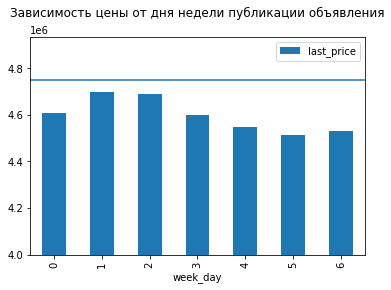

In [69]:
table_week_day = data.pivot_table(index='week_day', values='last_price', aggfunc='median')
table_week_day.plot.bar()
plt.ylim(4000000)
plt.axhline(y=4750000);
plt.title('Зависимость цены от дня недели публикации объявления', pad = 20)
plt.show;

День недели влияет на цену, цены которые выставляют во вторник и среду выше чем цены выставленные в другой день

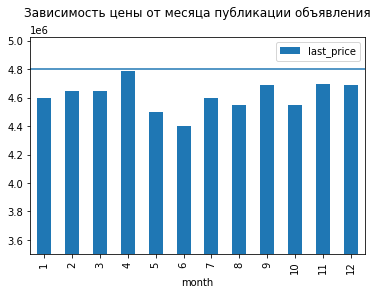

In [70]:
table_month = data.pivot_table(index='month', values='last_price', aggfunc='median')
table_month.plot.bar()
plt.ylim(3500000)
plt.axhline(y=4800000);
plt.title('Зависимость цены от месяца публикации объявления', pad = 20)
plt.show;

Месяц выставления объявления влияет на цену, цены которые выставляют в апреле выше чем цены выставленные в другой любой месяц

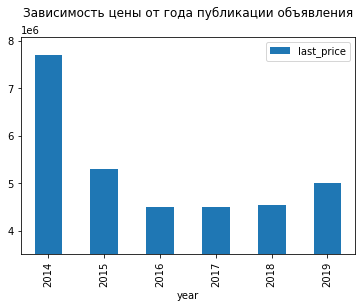

In [71]:
table_year = data.pivot_table(index='year', values='last_price', aggfunc='median')
table_year.plot.bar()
plt.ylim(3500000);
plt.title('Зависимость цены от года публикации объявления', pad = 20)
plt.show;

Год выставления объявления влияет на цену, цены которые указывали в 2014 году в 2 и более раз превышают цены других лет

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [72]:
data_top_10 = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count','mean'])
data_top_10.columns = ['count','mean']
data_top_10 = data_top_10.sort_values(by='count',ascending=False).query('count >= 237')
data_top_10

,count,mean
locality_name,,
Санкт-Петербург,15599,114067.249358
Мурино,590,86087.512050
Кудрово,472,95324.930544
Шушары,440,78677.364217
Всеволожск,398,68654.473986
Пушкин,367,103130.851744
Колпино,337,75333.295801
Парголово,326,90332.263023
Гатчина,307,68746.146763


Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [73]:
data_top_10[data_top_10['mean'] == data_top_10['mean'].min()]

,count,mean
locality_name,,
Выборг,237,58141.909153


Объявления, с минимальной стоимостью квадратного метра находятся в Выборге 

In [74]:
data_top_10[data_top_10['mean'] == data_top_10['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,15599,114067.249358


Объявления, с максимальной стоимостью квадратного метра находятся в Санкт-Петербурге  

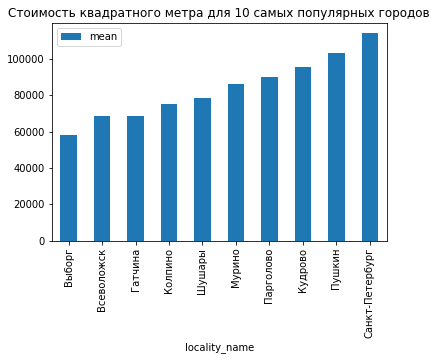

In [75]:
data_top_10 = data_top_10.sort_values(by='mean')
data_top_10.plot.bar(y='mean');
plt.title('Стоимость квадратного метра для 10 самых популярных городов')
plt.show;

Вычислим среднюю цену каждого километра в Санкт-Перербурге

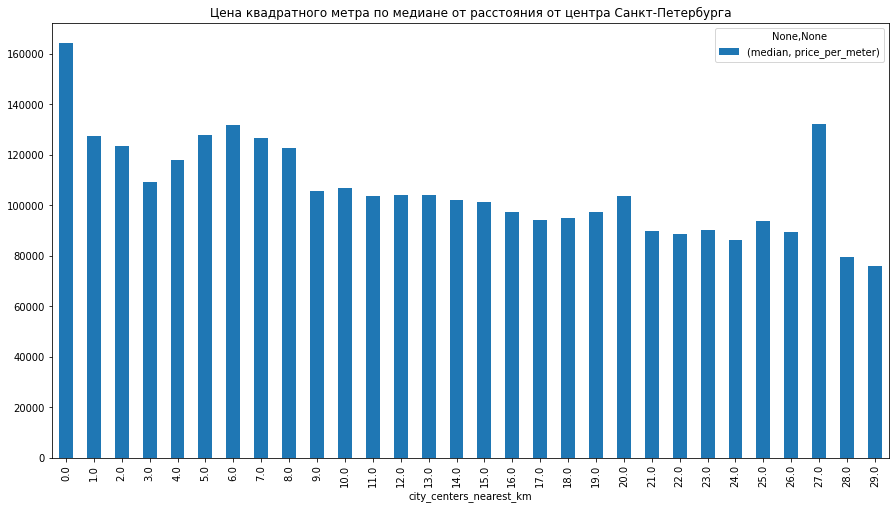

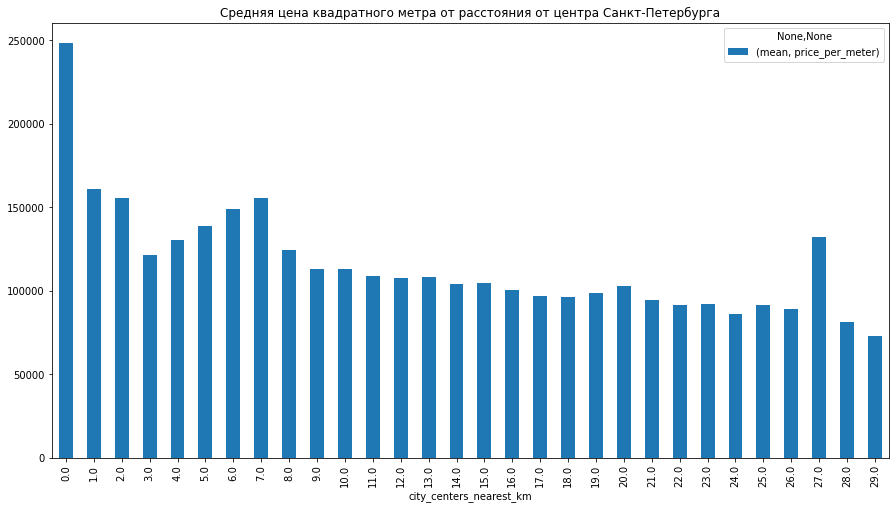

In [76]:
data_piter = data.query('locality_name == "Санкт-Петербург"')
data_piter = data_piter.pivot_table(index='city_centers_nearest_km', values='price_per_meter', aggfunc=['median','mean'])
data_piter.plot.bar(y=('median','price_per_meter'), figsize=(15,8));
plt.title('Цена квадратного метра по медиане от расстояния от центра Санкт-Петербурга')
plt.show;
data_piter.plot.bar(y=('mean','price_per_meter'), figsize=(15,8));
plt.title('Средняя цена квадратного метра от расстояния от центра Санкт-Петербурга')
plt.show;

Самые дорогие квартиры находятся в центре Санкт-Петербурга, удаляясь от центра города, стоимость квартиры будет снижаться, но за редким исключением, под влиянием других факторов, цена квадратного метра локально возрастает на отрезках с 3 до 7 км , с 19 до 20 км, с 24 до 25 км и на 27 км для средней стоимости и на отрезках с 3 до 6 км , с 18 до 20 км, с 24 до 25 км и на 27 км для медианы.

**Вывод: в результате исследования можно сказать, что чаще всего выставляют объявления для квартир:**
* Площадью около 50м
* Жилой площадью 20-40м
* Площадью кухни 8-10м
* Количеством комнат равным 1-2
* Высотой потолка равной около 2.7м
* Находящихся не на первых и не на последних этажах
* В домах ниже 8 этажа
* Находящихся от центра города на расстоянии 10000-15000 м 
* Находящихся от аэропорта на расстоянии 23000-25000 м
* Выставленных в будние дни весной или в октябре

**Также можно выделить что на цену влияют все исследование характеристики**


### Общий вывод

**Проверив все гипотезы, можно сделать вывод о том, что:**

Чаще всего выставляют объявления для квартир:
* Площадью около 50м
* Жилой площадью 20-40м
* Площадью кухни 8-10м
* Количеством комнат равным 1-2
* Высотой потолка равной около 2.7м
* Находящихся не на первых и не на последних этажах
* В домах ниже 8 этажа
* Находящихся от центра города на расстоянии 10000-15000 м 
* Находящихся от аэропорта на расстоянии 23000-25000 м
* Выставленных в будние дни весной или в октябре

Цена зависит от таких факторов как: 
* Общая площадь квартиры
* Жилая площадь
* Площадь кухни
* Количество комнат в квартире
* Типа этажа
* Дня недели, когда выставили объявление
* Года, когда выставили объявление


Если брать выборку по 10 городам с наибольшим количеством объявлений, то можно сказать что в Санкт-Петербурге самая высокая средняя цена за квадратный метр, а в Выборге самая минимальная цена за квадратный метр.

Также можно отметить, что в Санкт-Петербурге цена квартиры снижается в зависимости от удаления от центра города, но за редким исключением, под влиянием других факторов, цена квадратного метра локально возрастает на отрезках с 3 до 7 км , с 19 до 20 км, с 24 до 25 км и на 27 км для средней стоимости и на отрезках с 3 до 6 км , с 18 до 20 км, с 24 до 25 км и на 27 км для медианы.